In [2]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')
import numpy as np
import matplotlib.pyplot as plt
from utils.preprocessing import split,StandardScaler, MinMaxScaler
from numpy.random import default_rng
import importlib
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP

In [3]:
rng = default_rng()
n = 1000
data = np.empty((n, 3))
data[:,0] = rng.normal(loc = 10, scale = 0.1, size = n)
data[:,1] = rng.normal(loc = 5, scale = 0.1, size = n)
data[:,2] = rng.normal(loc = 1, scale = 0.1, size = n)
std = StandardScaler()
std.fit(data)
norm_data = std.fit_transform(data)
back_original = std.inverse_transform(norm_data)

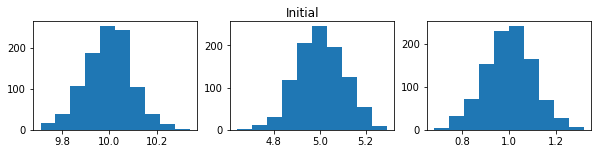

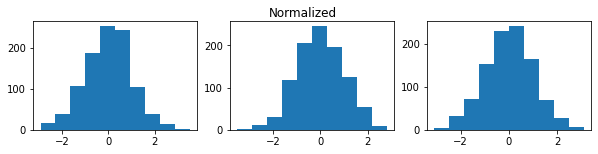

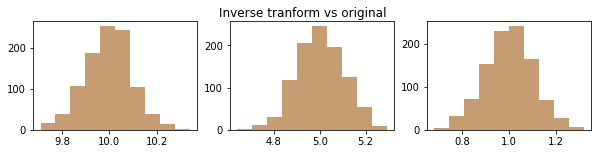

In [4]:
fig, axs = plt.subplots(1, 3, figsize = (10, 2))
for i, d in enumerate(data.T):
    axs[i].hist(d)
plt.suptitle('Initial')
plt.show()

fig, axs = plt.subplots(1, 3, figsize = (10, 2))
for i, d in enumerate(norm_data.T):
    axs[i].hist(d)
plt.suptitle('Normalized')
plt.show()

fig, axs = plt.subplots(1, 3, figsize = (10, 2))
for i, (d, ori_d) in enumerate(zip(back_original.T, data.T)):
    axs[i].hist(d, alpha = 0.5, label = 'inverse tranform')
    axs[i].hist(ori_d, alpha = 0.5, label = 'original')
plt.suptitle('Inverse tranform vs original')
plt.show()


In [230]:
def plot_results(network, labels, val_labels, out_scaler = None):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    if out_scaler != None:
        train_pred = out_scaler.inverse_transform(train_pred)
        val_pred = out_scaler.inverse_transform(val_pred)

    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


In [231]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]

# Shuffle data
np.random.shuffle(raw_data)

# Normalize data
norm_data = MinMaxScaler()
raw_data[:,1:-2] = norm_data.fit_transform(raw_data[:,1:-2])
# Normalize labels (outputs)
norm_labels = MinMaxScaler()
raw_data[:,-2:] = norm_labels.fit_transform(raw_data[:,-2:])

In [232]:
frac_test=0.15
data, test_set=split(raw_data,kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training,validation=split(data,kind="hold_out",frac_training=frac_training)

input_data=training[:,1:-2]
labels=training[:,-2:]
original_labels = norm_labels.inverse_transform(labels)
val_data=validation[:,1:-2]
val_labels=validation[:,-2:]
original_val_labels = norm_labels.inverse_transform(val_labels)

In [233]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [257]:
structure=[10,np.shape(labels)[1]]
act_func=[("sigmoid",1),("linear",1)]
start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

In [260]:
N_epoch = 5000
lamb=0.#1e-5
batch_size = -1 #-1 for batch gradient descent
alpha=0.1
nesterov=True
eta=1e-4
beta=0.4
netw.train(input_data, labels, val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta =eta, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta)

Epoch 10000:  [train MEE = 0.0980]  [val MEE = 0.0990]                              
Elapsed time: 9.475579738616943 s


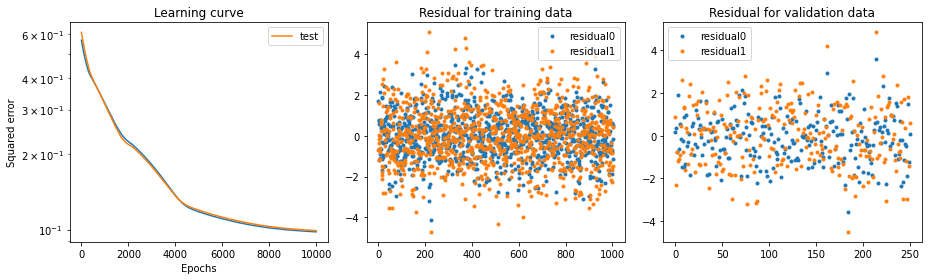

In [261]:
plot_results(netw, original_labels, original_val_labels, out_scaler = norm_labels)